In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://media.githubusercontent.com/media/enricochandran/Dataset-ML/refs/heads/main/UTSClustering.csv', encoding='latin-1')
data.drop_duplicates(inplace=True)
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
features = data[['Quantity', 'UnitPrice', 'TotalPrice']].copy()

In [3]:
numeric_data = data.select_dtypes(include=[np.number])

vt = VarianceThreshold(threshold=0.01)
vt.fit(numeric_data)
low_var_cols = [col for col in numeric_data.columns if col not in numeric_data.columns[vt.get_support()]]
data.drop(columns=low_var_cols, inplace=True)

dup_cols = []
for i in range(len(data.columns)):
    for j in range(i+1, len(data.columns)):
        if data.iloc[:, i].equals(data.iloc[:, j]):
            dup_cols.append(data.columns[j])
data.drop(columns=dup_cols, inplace=True)

corr_matrix = data.select_dtypes(include=[np.number]).corr()
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.add(corr_matrix.columns[i])
data.drop(columns=list(high_corr), inplace=True)

X_mi = data.select_dtypes(include=[np.number]).fillna(data.median(numeric_only=True))
kmeans_temp = KMeans(n_clusters=3, random_state=42, n_init=10)
temp_labels = kmeans_temp.fit_predict(X_mi)
mi_scores = [(col, mutual_info_classif(X_mi[[col]], temp_labels, random_state=42)[0]) for col in X_mi.columns]
mi_scores.sort(key=lambda x: x[1], reverse=True)
selected_features = [col for col, score in mi_scores if score > 0.05]

In [6]:
X = data[selected_features].copy()

X = X.fillna(X.median()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_model = PCA(n_components=min(len(selected_features), 5))
X_pca = pca_model.fit_transform(X_scaled)
cum_var = np.cumsum(pca_model.explained_variance_ratio_)
n_comp = np.argmax(cum_var >= 0.9) + 1
pca_model = PCA(n_components=max(2, n_comp))
X_pca_final = pca_model.fit_transform(X_scaled)

In [7]:
sample = pd.DataFrame(X_scaled).sample(n=2000, random_state=42).values
clustering_algos = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42),
    "Spectral": SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42, n_neighbors=15)
}

labels_dict = {}
eval_scores = {}

for name, model in clustering_algos.items():
    try:
        labels = model.fit_predict(sample)
        labels_dict[name] = labels
        eval_scores[name] = {
            'Silhouette': silhouette_score(sample, labels),
            'Davies-Bouldin': davies_bouldin_score(sample, labels),
            'Calinski-Harabasz': calinski_harabasz_score(sample, labels)
        }
    except Exception as e:
        print(f"{name} error: {e}")

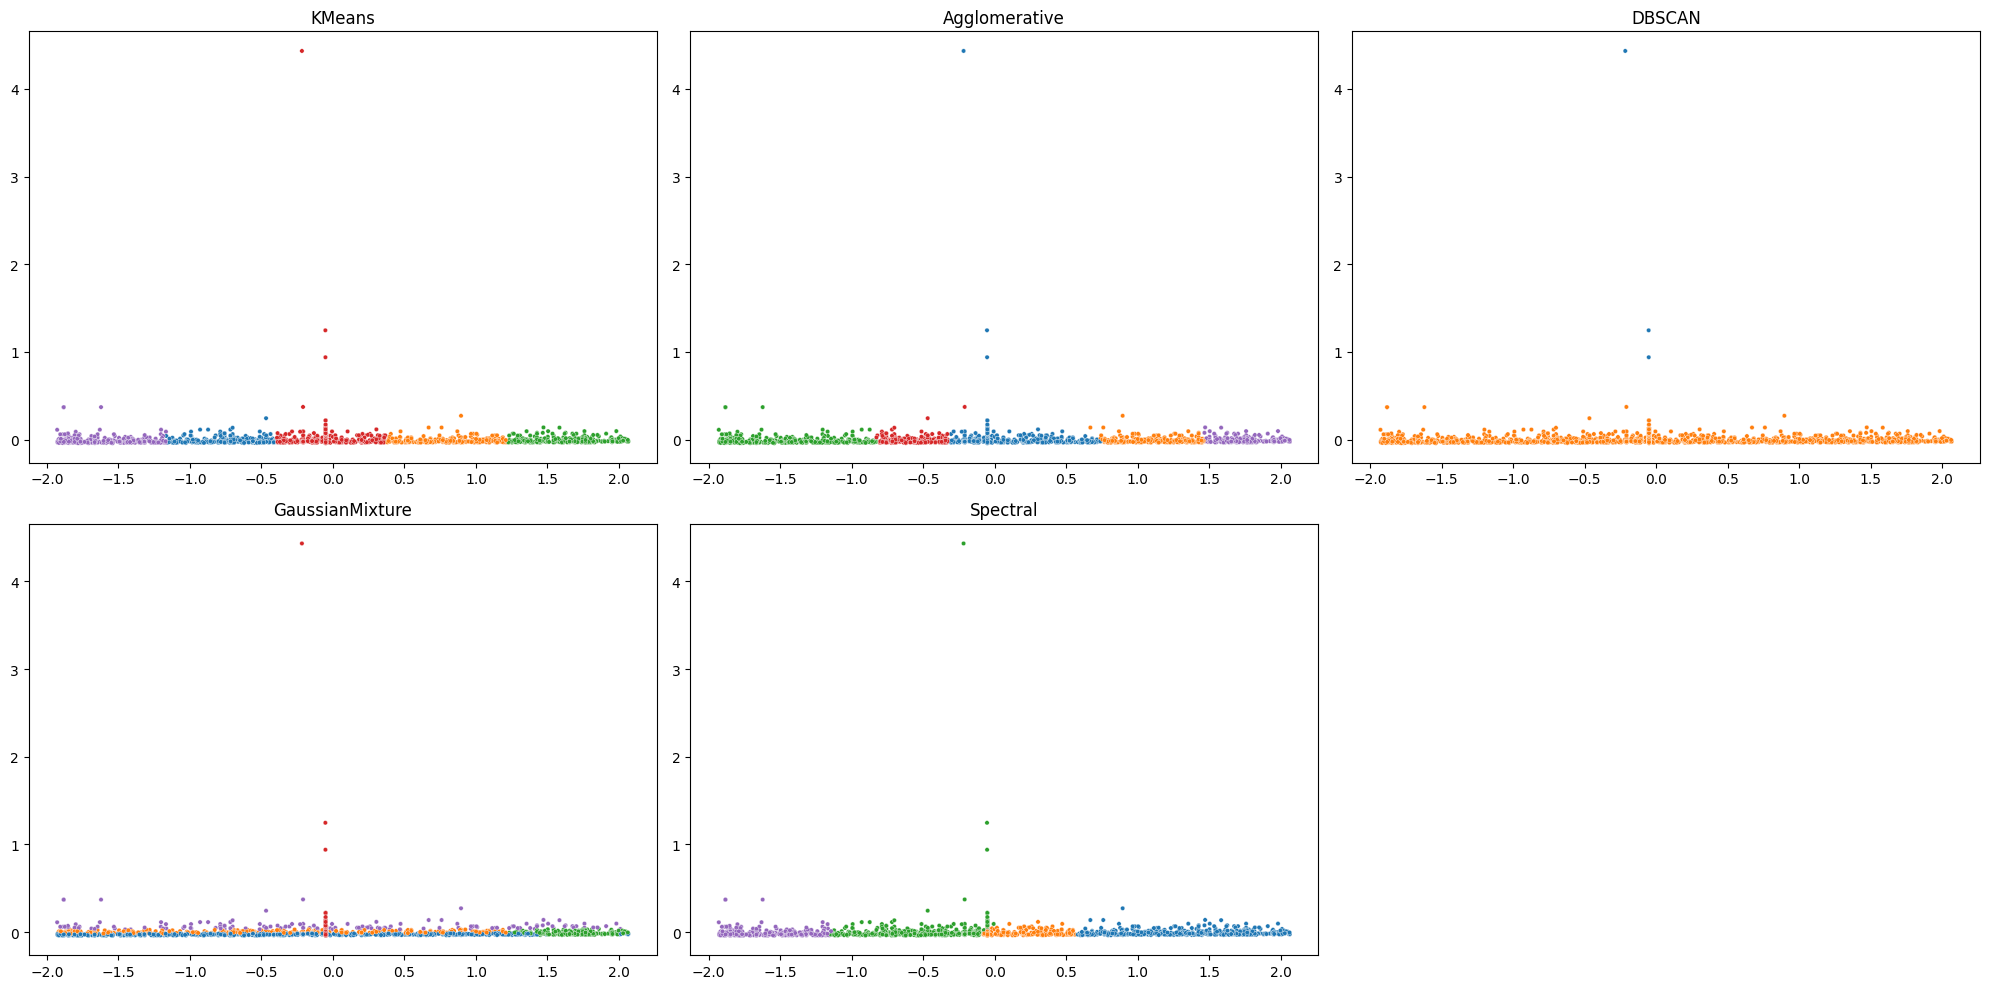

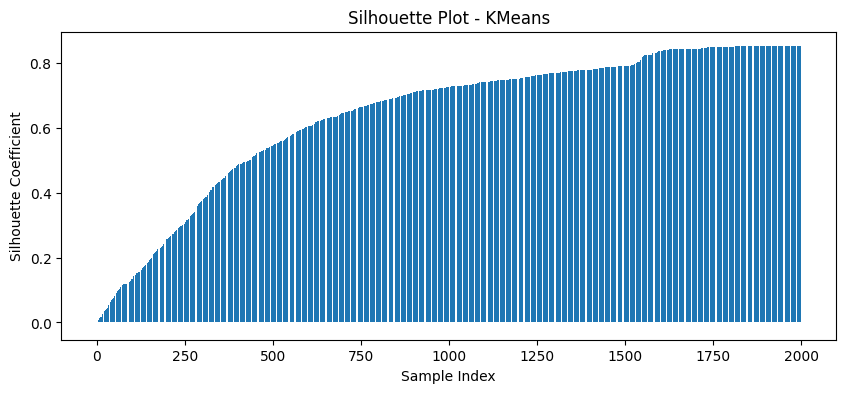

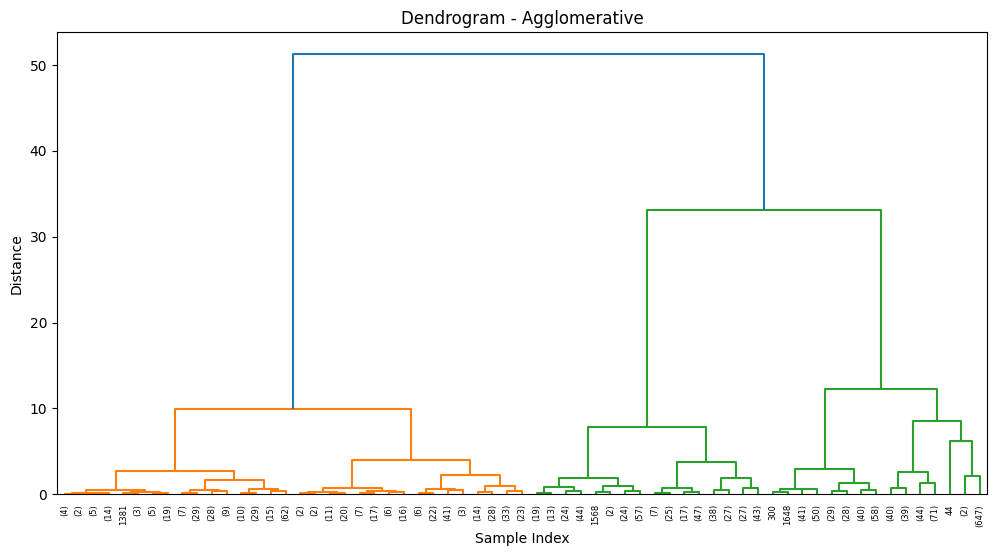

In [8]:
plt.figure(figsize=(20, 10))
for i, (name, labels) in enumerate(labels_dict.items()):
    pca_result = PCA(n_components=2).fit_transform(sample)
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='tab10', s=10, legend=False)
    plt.title(name)
plt.tight_layout()
plt.show()

kmeans_labels = labels_dict['KMeans']
sil_vals = silhouette_samples(sample, kmeans_labels)
plt.figure(figsize=(10, 4))
plt.bar(range(len(sil_vals)), np.sort(sil_vals))
plt.title("Silhouette Plot - KMeans")
plt.xlabel("Sample Index")
plt.ylabel("Silhouette Coefficient")
plt.show()

linked = linkage(sample, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram - Agglomerative")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [9]:
print("\nEvaluation Metrics:")
eval_df = pd.DataFrame(eval_scores).T
print(eval_df.sort_values('Silhouette', ascending=False))


Evaluation Metrics:
                 Silhouette  Davies-Bouldin  Calinski-Harabasz
KMeans             0.640148        0.454330        9873.137595
Agglomerative      0.558785        0.510561        7342.669887
DBSCAN             0.543941        1.028692          13.911165
Spectral           0.100580        0.883384        4470.921040
GaussianMixture    0.084032       11.507995         336.283522


# Matriks Evaluasi Terbaik

Matriks evaluasi terbaik untuk membandingkan model klasterisasi adalah Silhouette Score, karena:

*   Silhouette Score mengukur seberapa mirip suatu data dengan klasternya sendiri dibandingkan dengan klaster lain.
*   Rentang nilainya antara -1 hingga 1.
*   Nilai mendekati 1 menunjukkan klasterisasi yang baik, di mana data-data dalam klaster serupa dan terpisah dengan baik dari klaster lain.
*   Davies-Bouldin Index dan Calinski-Harabasz Index juga digunakan, tetapi interpretasinya berbeda. Semakin kecil nilai Davies-Bouldin dan semakin besar nilai Calinski-Harabasz, semakin baik klasterisasinya. Namun, Silhouette Score lebih mudah diinterpretasikan dan memberikan gambaran yang lebih jelas tentang kualitas klaster.

# Penjelasan untuk setiap model klasterisasi yang digunakan

*   KMeans: Membagi data ke dalam sejumlah klaster (k) berdasarkan jarak data ke pusat klaster (centroid).
*   Agglomerative: Membangun hirarki klaster dengan menggabungkan klaster-klaster terdekat secara berulang.
*   DBSCAN: Mengelompokkan data berdasarkan kepadatan. Data yang berdekatan dan memiliki kepadatan yang cukup tinggi akan membentuk klaster.
*   GaussianMixture: Memodelkan data sebagai campuran dari beberapa distribusi Gaussian. Klaster dibentuk berdasarkan probabilitas data termasuk dalam distribusi tertentu.
*   Spectral: Membangun graf berdasarkan kemiripan data dan melakukan klasterisasi pada graf tersebut.

# Analisis dan Model Terbaik

Model terbaik adalah KMeans. Hal ini karena KMeans memiliki Silhouette Score tertinggi dibandingkan dengan model lainnya. Ini menunjukkan bahwa KMeans menghasilkan klaster yang lebih baik di mana data-data dalam klaster serupa dan terpisah dengan baik dari klaster lain.

# Alasan KMeans menjadi model terbaik:

*   Data yang digunakan mungkin memiliki struktur klaster yang sesuai dengan asumsi KMeans, yaitu klaster berbentuk bola dengan ukuran dan kepadatan yang relatif sama.
*   Parameter KMeans (jumlah klaster) telah di-tuning dengan baik, sehingga menghasilkan klaster yang optimal.
*   KMeans relatif mudah diimplementasikan dan diinterpretasikan.